In [558]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)

#Tensorflow
import tensorflow as tf
tf.random.set_seed(2)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

#Pandas
import pandas as pd 

#Keras
from keras import backend as K
from keras import metrics
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

#Statistics Libraries
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
from scipy import interp
import math as m
from itertools import cycle

#plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

#OverSampling
from imblearn.over_sampling import RandomOverSampler

#SKlearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#global
import os, glob

import warnings
warnings.filterwarnings("ignore")

In [559]:
datasource_path = os.path.join(os.getcwd(), r'../../../Datasets/Junio2020/procesados_classification/')
filenames = glob.glob(datasource_path + "/*.csv")
pwd = os.getcwd()
filenames.sort()
for file in filenames:
    print(filenames.index(file), ' ', os.path.basename(file))

0   3C-EURUSD_FULL_1D_145F.csv
1   3C-EURUSD_FULL_1D_145F_0.0017Sep.csv
2   3C-EURUSD_FULL_1D_145F_0.0018Sep.csv
3   3C-EURUSD_FULL_1D_145F_0.0019Sep.csv
4   3C-EURUSD_FULL_1D_145F_0.0025Sep.csv
5   3C-EURUSD_FULL_1D_145F_0.0028Sep.csv
6   3C-EURUSD_FULL_1D_145F_0.0029Sep.csv
7   3C-EURUSD_FULL_1D_145F_0.002Sep.csv
8   3C-EURUSD_FULL_1D_145F_0.0032Sep.csv
9   3C-EURUSD_FULL_1D_145F_0.0035Sep.csv
10   3C-EURUSD_FULL_1D_145F_0.003Sep.csv
11   3C-EURUSD_FULL_1D_21F.csv
12   3C-EURUSD_FULL_1D_45F.csv
13   3C-EURUSD_FULL_1D_45F_0.0029Sep.csv
14   3C-EURUSD_FULL_1D_70F.csv
15   3C-EURUSD_FULL_1D_70F_0.0029Sep.csv
16   3C-EURUSD_FULL_1H_45F.csv
17   5C-EURUSD_FULL_1D_21F.csv
18   5C-EURUSD_FULL_1D_27F.csv
19   5C-EURUSD_FULL_1D_45F.csv
20   5C-EURUSD_FULL_1D_70F.csv
21   C-EURUSD_FULL_1D_21F.csv
22   C-EURUSD_FULL_1H_25F.csv
23   C-EURUSD_FULL_1H_45F.csv
24   C-EURUSD_FULL_1H_54F.csv


In [560]:
#SELECT an INDEX 
INDX = 7

CLASS_NUMBER = '3C'
MODEL_TYPE = 'LSTM'
FRECUENCIA = '1D'
TARGET_NAME = "Class"
ID = '02'

LAYER1_UNITS =64
RANGE = 5
EPOCHS = 30
BATCH_SIZE = 32
TEST_SIZE = .20
VAL_SIZE = .20


In [561]:
base =  os.path.basename(filenames[INDX])
print(base)
FILE_NAME_BASE = os.path.splitext(base)[0]
print(FILE_NAME_BASE)

3C-EURUSD_FULL_1D_145F_0.002Sep.csv
3C-EURUSD_FULL_1D_145F_0.002Sep


In [562]:
if FRECUENCIA =="1D":
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
else:
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
DATASET = pd.read_csv(filenames[INDX], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
NUM_FEATURES = DATASET.shape[1]
DATASET.head(2)

,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,...,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr,Class
0,2004-01-01,1.25950,1.26052,1.24698,1.25733,4.621817e+05,1.25934,1.26035,1.24679,1.25723,...,76.440177,76.440177,-23.559823,0.0,1.257330,0.0,-0.522913,0.000000,0.000000,0.0
1,2004-01-02,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.25701,1.26263,1.25198,1.25806,...,71.590909,74.015543,-28.409091,0.0,1.257865,0.0,0.078738,0.078707,0.078738,1.0


In [563]:
SIZE = DATASET.shape[0]
SIZE

5137

In [564]:
HYPER_L1_IN = RANGE

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [565]:
REVOME_FEATURES = True
# In base of XGBoost Feature Analisis I'll remove some features from the 145 original dataset.
#Describe DATASET
if (REVOME_FEATURES):
    print('Shape: ', DATASET.shape)
    print(DATASET.describe())
    DATASET = DATASET.drop(['MACD_5_25'], axis = 1)
    DATASET = DATASET.drop(['momentum_roc'], axis = 1)
    DATASET = DATASET.drop(['trend_mass_index'], axis = 1)
    DATASET = DATASET.drop(['trend_aroon_ind'], axis = 1)
    DATASET = DATASET.drop(['trend_visual_ichimoku_a'], axis = 1)
    DATASET = DATASET.drop(['AQM_Pct_Range_Close'], axis = 1)
    DATASET = DATASET.drop(['trend_kst'], axis = 1)
    DATASET = DATASET.drop(['MACDsign_5_25'], axis = 1)
    DATASET = DATASET.drop(['MA_Close_150'], axis = 1)
    DATASET = DATASET.drop(['rsi_25'], axis = 1)
    DATASET = DATASET.drop(['trend_macd'], axis = 1)
    #DATASET = DATASET.drop(['High'], axis = 1)
    DATASET = DATASET.drop(['MA_Close_200'], axis = 1)
    DATASET = DATASET.drop(['volatility_bbl'], axis = 1)
    DATASET = DATASET.drop(['volatility_bbh'], axis = 1)
    DATASET = DATASET.drop(['Bollinger_Low'], axis = 1)
    DATASET = DATASET.drop(['MA_Close_5'], axis = 1)
    DATASET = DATASET.drop(['MA_Close_25'], axis = 1)
    #DATASET = DATASET.drop(['Low'], axis = 1)
    DATASET = DATASET.drop(['trend_psar_down'], axis = 1)
    DATASET = DATASET.drop(['momentum_tsi'], axis = 1)
    DATASET = DATASET.drop(['MA_Close_175'], axis = 1)
    DATASET = DATASET.drop(['trend_macd_signal'], axis = 1)
    DATASET = DATASET.drop(['trend_visual_ichimoku_b'], axis = 1)
    DATASET = DATASET.drop(['Bollinger_High'], axis = 1)
    #DATASET = DATASET.drop(['Close'], axis = 1)
    DATASET = DATASET.drop(['momentum_rsi'], axis = 1)
    DATASET = DATASET.drop(['volatility_kcc'], axis = 1)
    DATASET = DATASET.drop(['trend_psar_up'], axis = 1)
    DATASET = DATASET.drop(['others_dr'], axis = 1)
    DATASET = DATASET.drop(['volume_vwap'], axis = 1)
    DATASET = DATASET.drop(['trend_psar_down_indicator'], axis = 1)
    DATASET = DATASET.drop(['trend_ema_slow'], axis = 1)
    DATASET = DATASET.drop(['trend_ichimoku_a'], axis = 1)
    DATASET = DATASET.drop(['trend_ema_fast'], axis = 1)
    DATASET = DATASET.drop(['trend_ichimoku_base'], axis = 1)
    DATASET = DATASET.drop(['trend_ichimoku_b'], axis = 1)
    DATASET = DATASET.drop(['trend_ichimoku_conv'], axis = 1)
    DATASET = DATASET.drop(['volatility_kch'], axis = 1)
    DATASET = DATASET.drop(['volatility_dcl'], axis = 1)
    DATASET = DATASET.drop(['momentum_kama'], axis = 1)
    DATASET = DATASET.drop(['trend_trix'], axis = 1)
    DATASET = DATASET.drop(['EMA_Close_5'], axis = 1)
    DATASET = DATASET.drop(['trend_sma_fast'], axis = 1)
    DATASET = DATASET.drop(['volatility_dcm'], axis = 1)
    DATASET = DATASET.drop(['trend_psar_up_indicator'], axis = 1)
    DATASET = DATASET.drop(['volatility_dch'], axis = 1)
    DATASET = DATASET.drop(['volatility_bbm'], axis = 1)
    DATASET = DATASET.drop(['trend_sma_slow'], axis = 1)
    DATASET = DATASET.drop(['volatility_kcl'], axis = 1)
    DATASET = DATASET.drop(['Rolling_Mean25'], axis = 1)


Shape:  (5137, 145)
              Open         High          Low        Close        Volume  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03   
mean      1.263948     1.268773     1.259111     1.263939  4.156849e+05   
std       0.122827     0.123592     0.121990     0.122823  4.429918e+05   
min       1.039090     1.041820     1.034050     1.039090  5.400000e+01   
25%       1.149190     1.153490     1.145380     1.149120  1.159636e+05   
50%       1.270260     1.275990     1.265560     1.270260  2.200810e+05   
75%       1.350610     1.355180     1.345920     1.350700  7.439951e+05   
max       1.597400     1.604030     1.589800     1.597370  2.237468e+06   

          Open_Bid     High_Bid      Low_Bid    Close_Bid    Volume_Bid  ...  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03  ...   
mean      1.263810     1.268680     1.259015     1.263822  4.616911e+05  ...   
std       0.122817     0.123571     0.121969     0.122813  5.305

In [566]:
print(DATASET.shape)

(5137, 97)


In [567]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (5137, 97)
              Open         High          Low        Close        Volume  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03   
mean      1.263948     1.268773     1.259111     1.263939  4.156849e+05   
std       0.122827     0.123592     0.121990     0.122823  4.429918e+05   
min       1.039090     1.041820     1.034050     1.039090  5.400000e+01   
25%       1.149190     1.153490     1.145380     1.149120  1.159636e+05   
50%       1.270260     1.275990     1.265560     1.270260  2.200810e+05   
75%       1.350610     1.355180     1.345920     1.350700  7.439951e+05   
max       1.597400     1.604030     1.589800     1.597370  2.237468e+06   

          Open_Bid     High_Bid      Low_Bid    Close_Bid    Volume_Bid  ...  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03  ...   
mean      1.263810     1.268680     1.259015     1.263822  4.616911e+05  ...   
std       0.122817     0.123571     0.121969     0.122813  5.3052

In [568]:
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(4938, 95)
      Open     High      Low    Close        Volume  Open_Bid  High_Bid  \
0  1.23655  1.23817  1.22801  1.23179  1.078729e+06   1.23639   1.23804   
1  1.23158  1.23241  1.22967  1.23109  8.212280e+04   1.23088   1.23231   
2  1.23140  1.23154  1.21310  1.21496  1.130388e+06   1.23124   1.23140   
3  1.21495  1.21669  1.20594  1.20711  1.123270e+06   1.21479   1.21656   
4  1.20718  1.21160  1.20519  1.20794  1.118725e+06   1.20702   1.21156   

   Low_Bid  Close_Bid   Volume_Bid  ...  trend_aroon_up  trend_aroon_down  \
0  1.22791    1.23169  1291823.750  ...            76.0              28.0   
1  1.22955    1.23099    93508.000  ...            72.0              24.0   
2  1.21298    1.21486  1348137.000  ...            68.0              20.0   
3  1.20583    1.20701  1344214.000  ...            64.0              16.0   
4  1.20504    1.20784  1355827.375  ...            60.0              12.0   

   momentum_uo  momentum_stoch  momentum_stoch_signal  momentum_wr  \
0    

In [569]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  4938
Start:  0


In [570]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc

print(DF_Full.shape)

(4938, 95)


In [571]:

total = DATASET.shape[0]
print('Total: ', total)

Total:  5137


In [572]:
DF_Full[TARGET_NAME][0:12]

0     0.0
1    -1.0
2    -1.0
3     0.0
4     1.0
5    -1.0
6     0.0
7     1.0
8     1.0
9     0.0
10    0.0
11   -1.0
Name: Class, dtype: float64

### Generate VECTOR Y

In [573]:
#generate the VECTOR Y
uniques, ids = np.unique(DF_Full[TARGET_NAME], return_inverse=True)

#target_y = np_utils.to_categorical(DF_Full[TARGET_NAME],num_classes=5)
target_y = np_utils.to_categorical(ids,len(uniques))
print(ids)
print(uniques)
print(target_y)

[1 0 0 ... 2 1 1]
[-1.  0.  1.]
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [574]:
close_y = target_y
print(close_y[:10])   
#   [1. 0. 0. 0. 0.]   =  0
#   [0. 1. 0. 0. 0.]   =  1
#   [0. 0. 1. 0. 0.]   =   2 
#   [0. 0. 0. 1. 0.]   =  -2
#   [0. 0. 0. 0. 1.]   =  -1
close_y.shape

[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


(4938, 3)

### REMOVE COLUMNS 

In [575]:
#REMOVE CLASS FROM Data
print(DF_Full.shape)
DF_Full = DF_Full.drop(['Class'], axis = 1)
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
DF_Full.head()

(4938, 95)
(4938, 94)


,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,...,trend_kst_diff,trend_aroon_up,trend_aroon_down,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dlr,others_cr
0,1.23655,1.23817,1.22801,1.23179,1.078729e+06,1.23639,1.23804,1.22791,1.23169,1291823.750,...,8.132749,76.0,28.0,64.759073,81.313269,88.120556,-18.686731,0.010763,-0.368701,-2.031289
1,1.23158,1.23241,1.22967,1.23109,8.212280e+04,1.23088,1.23231,1.22955,1.23099,93508.000,...,7.361159,72.0,24.0,56.013733,77.982456,84.601906,-22.017544,0.010124,-0.056844,-2.086962
2,1.23140,1.23154,1.21310,1.21496,1.130388e+06,1.23124,1.23140,1.21298,1.21486,1348137.000,...,5.575709,68.0,20.0,43.726020,7.288401,55.528042,-92.711599,0.008048,-1.318880,-3.369839
3,1.21495,1.21669,1.20594,1.20711,1.123270e+06,1.21479,1.21656,1.20583,1.20701,1344214.000,...,3.034464,64.0,16.0,38.351979,3.580171,29.617010,-96.419829,0.004506,-0.648208,-3.994178
4,1.20718,1.21160,1.20519,1.20794,1.118725e+06,1.20702,1.21156,1.20504,1.20784,1355827.375,...,0.230380,60.0,12.0,38.098091,8.226144,6.364906,-91.773856,-0.000011,0.068736,-3.928165


### SPLIT in 3 Sub Datasets

In [576]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)

end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.4
count of Val and Test: 2054
end of train:  3083
count val:  1027
count test:  1027
end_val 4110


In [577]:
close_y[:end_train,:]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [578]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print("data_training.shape: ",data_training.shape)
print("data_val.shape: ", data_val.shape)
print("data_test.shape: ", data_test.shape)

data_training_y = close_y[:end_train,:]
data_val_y = close_y[end_train: end_val,:]
data_test_y = close_y[end_val:,:]

print("data_training_y.shape: ", data_training_y.shape)
print("data_val_y.shape: ", data_val_y.shape)
print("data_test_y.shape: ", data_test_y.shape)

data_training.shape:  (3083, 94)
data_val.shape:  (1027, 94)
data_test.shape:  (828, 94)
data_training_y.shape:  (3083, 3)
data_val_y.shape:  (1027, 3)
data_test_y.shape:  (828, 3)


In [579]:
data_test['Close'].head(10)

4110    1.17427
4111    1.17414
4112    1.18138
4113    1.18644
4114    1.18314
4115    1.18223
4116    1.18149
4117    1.17948
4118    1.17716
4119    1.17946
Name: Close, dtype: float64

In [580]:
uniques_data_test_y = uniques[data_test_y.argmax(1)]
uniques_data_test_y[:10]

array([ 0.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  1.])

### SCALAR

In [581]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[0.16128208 0.15335663 0.14996946 ... 0.5366395  0.38397864 0.15028821]
 [0.14973038 0.14002731 0.15386965 ... 0.53369965 0.43448271 0.14866121]
 [0.14931201 0.13801402 0.11493821 ... 0.52415051 0.23010041 0.11117051]
 ...
 [0.44619282 0.43845602 0.45402002 ... 0.47604876 0.45440868 0.44837765]
 [0.44830792 0.44174207 0.45622856 ... 0.48041045 0.45035521 0.44967925]
 [0.44960952 0.44718025 0.46022273 ... 0.48257701 0.47009059 0.45483916]]


(3083, 94)
[0.37669362 0.42690746 0.22466157 0.33182137 0.44717204 0.47414792
 0.30587499 0.43527102 0.48605834 0.61154273]


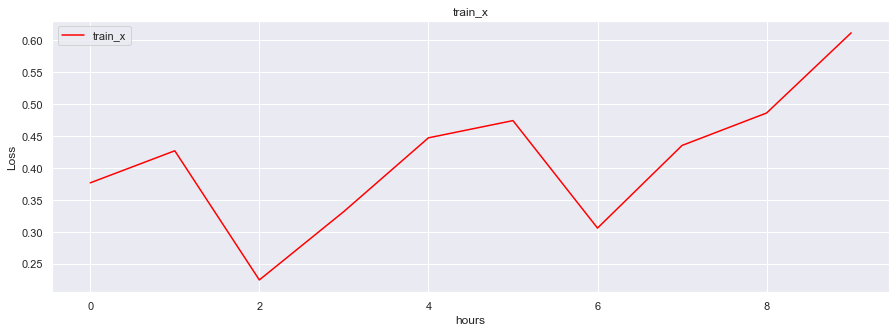

In [582]:
print(data_training_array_scaled.shape)
print(data_training_array_scaled[:10,12])
plt.figure(figsize=(15,5))
plt.plot(data_training_array_scaled[:10,12], color = 'red', label = 'train_x')
plt.title('train_x')
plt.xlabel('hours')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [583]:
data_training_y[:10]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

### CHART MA's

(3083, 94)


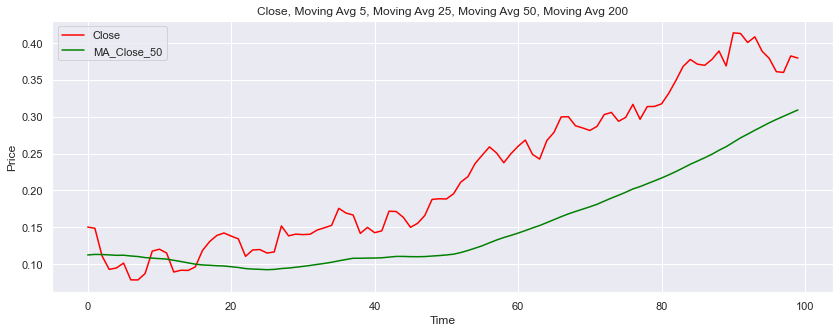

In [584]:
INICIO = 0
FIN = 100

IDX_Close = DF_Full.columns.get_loc("Close")
IDX_MA_Close_50 = DF_Full.columns.get_loc("MA_Close_50")

print(data_training_array_scaled.shape)
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_50], color = 'green', label = 'MA_Close_50')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(3083, 94)


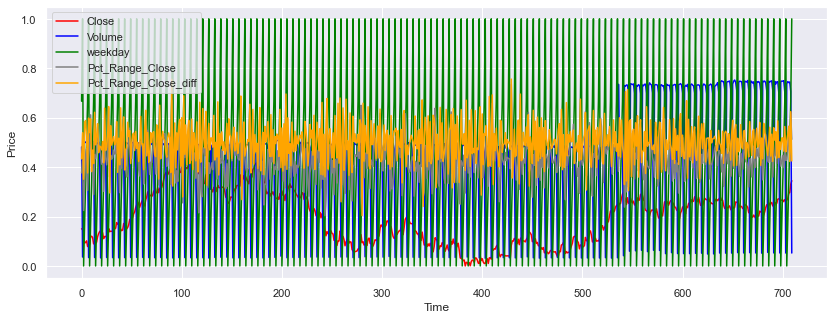

In [585]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 710


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Volume = DF_Full.columns.get_loc("Volume")
IDX_weekday = DF_Full.columns.get_loc("weekday")
IDX_Pct_Range_Close = DF_Full.columns.get_loc("Pct_Range_Close")
IDX_Pct_Range_Close_diff = DF_Full.columns.get_loc("Pct_Range_Close_diff")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Volume], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_weekday], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close_diff], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(3083, 94)


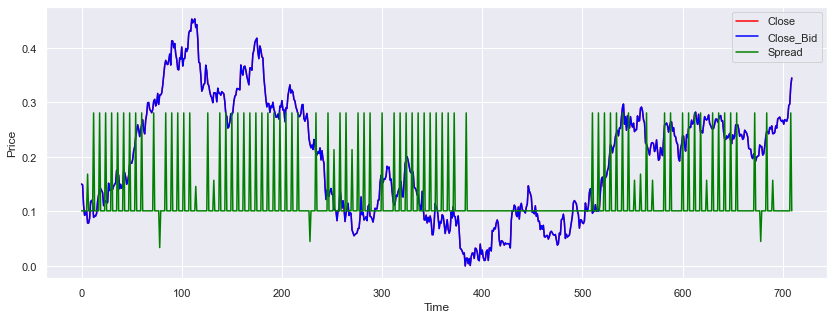

In [586]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 710


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Close_Bid = DF_Full.columns.get_loc("Close_Bid")
IDX_Spread = DF_Full.columns.get_loc("Spread")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close_Bid], color = 'blue', label = 'Close_Bid')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Spread], color = 'green', label = 'Spread')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [587]:
data_training_y

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [588]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    indx_start = i-RANGE
    X_train.append(data_training_array_scaled[indx_start:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(3078, 5, 94)
(3078, 3)


In [589]:
X_train_np[0,:,3]

array([0.15028821, 0.14866121, 0.11117051, 0.09292488, 0.09485403])

In [590]:
array = y_train_np[:RANGE]
uniques_y = uniques[array.argmax(1)]
print(uniques_y)

[-1.  0.  1.  1.  0.]


In [591]:
#
#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
#print(data_val_x1.head)

(5, 94)
(1027, 94)


(1032, 94)

In [592]:
last_range_train_y = data_training_y[-RANGE:]
last_range_train_y

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [593]:
last_range_train_y.shape

(5, 3)

In [594]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y[-RANGE:]
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = np.concatenate((last_range_train_y,data_val_y))
print(data_val_y1.shape)
print(data_val_y1[:10])

(5, 3)
(1027, 3)
(1032, 3)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [595]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
#print(data_val_x2[:10])

(1032, 94)

In [596]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    indx_start = i-RANGE
    X_val.append(data_val_x2[indx_start:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(1027, 5, 94)
(1027, 3)


In [597]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(5, 94)
(828, 94)


(833, 94)

In [598]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y[-RANGE:,:]
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = np.concatenate((last_range_training_y,data_test_y))
print(data_test_y1.shape)

(5, 3)
(828, 3)
(833, 3)


In [599]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
#print(data_test_x2[:10])

(833, 94)

In [600]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(828, 5, 94)
(828, 3)


In [601]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

5
94


### Oversampling Inbalanced Class

In [602]:
#Check Current Shape
print(X_train_np.shape)
print(y_train_np.shape)

(3078, 5, 94)
(3078, 3)


In [603]:
#oversample = RandomOverSampler(sampling_strategy='minority')
#oversample


In [604]:
#X_over, y_over = oversample.fit_resample(X_train_np, y_train_np)

In [605]:
#GET ID
results_path_lstm = os.path.join(pwd, r'../../../Results/LSTM/Optimized/')
filenames_results = glob.glob(results_path_lstm + "/*.csv")
newID = len(filenames_results) +1
newID

33

In [606]:
#LOCATION TO SAVE
pwd = os.getcwd()
source_data_toSave = os.path.join(pwd, r'../../../Models/2020/LSTM/Optimized/')
#FILENAME =  FILE_NAME_BASE + '__' + str(SIZE) + 'Size_' + MODEL_TYPE + '_' + str(RANGE) + 'Prof_' + str(EPOCHS) + 'Epochs' + '_' +  "{:.2f}".format(acc) + 'acc_' + TARGET_NAME + "_"+ str(newID) 
FILENAME =  FILE_NAME_BASE +'_' + str(newID) 
file_name_toSave = FILENAME + '.hdf5'
print('FILENAME: ', FILENAME)
print('File Name Model:', file_name_toSave)


FILENAME:  3C-EURUSD_FULL_1D_145F_0.002Sep_33
File Name Model: 3C-EURUSD_FULL_1D_145F_0.002Sep_33.hdf5


In [607]:
#testVal_results_csv = os.path.join(source_data_toSave + FILENAME + '_TestVal.csv')
#print(testVal_results_csv)
test_results_csv = os.path.join(results_path_lstm + FILENAME + '_Test.csv')
print(test_results_csv)
train_results_csv = os.path.join(results_path_lstm + FILENAME + '_Train.csv')
print(train_results_csv)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/LSTM/Optimized/3C-EURUSD_FULL_1D_145F_0.002Sep_33_Test.csv
C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/LSTM/Optimized/3C-EURUSD_FULL_1D_145F_0.002Sep_33_Train.csv


### BUILD LSTM MODEL 

In [608]:
model = Sequential()
model.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
model.add(LSTM(units = LAYER1_UNITS, activation = 'relu'))
model.add(Dense(units = 3, activation = 'softmax'))
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["acc"])


In [609]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 5, 5)              2000      
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 20,115
Trainable params: 20,115
Non-trainable params: 0
_________________________________________________________________


In [610]:
history = model.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)

Epoch 1/30
97/97 [==============================] - 1s 11ms/step - loss: 1.0943 - acc: 0.3843 - val_loss: 1.0869 - val_acc: 0.4187
Epoch 2/30
97/97 [==============================] - 1s 7ms/step - loss: 1.0905 - acc: 0.3928 - val_loss: 1.0970 - val_acc: 0.4216
Epoch 3/30
97/97 [==============================] - 1s 7ms/step - loss: 1.0870 - acc: 0.3941 - val_loss: 1.0839 - val_acc: 0.4197
Epoch 4/30
97/97 [==============================] - 1s 7ms/step - loss: 1.0850 - acc: 0.4006 - val_loss: 1.0839 - val_acc: 0.4255
Epoch 5/30
97/97 [==============================] - 1s 7ms/step - loss: 1.0827 - acc: 0.4025 - val_loss: 1.0856 - val_acc: 0.4255
Epoch 6/30
97/97 [==============================] - 1s 7ms/step - loss: 1.0816 - acc: 0.4058 - val_loss: 1.0860 - val_acc: 0.4216
Epoch 7/30
97/97 [==============================] - 1s 7ms/step - loss: 1.0794 - acc: 0.4110 - val_loss: 1.0877 - val_acc: 0.4255
Epoch 8/30
97/97 [==============================] - 1s 6ms/step - loss: 1.0794 - acc: 0.4

In [611]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


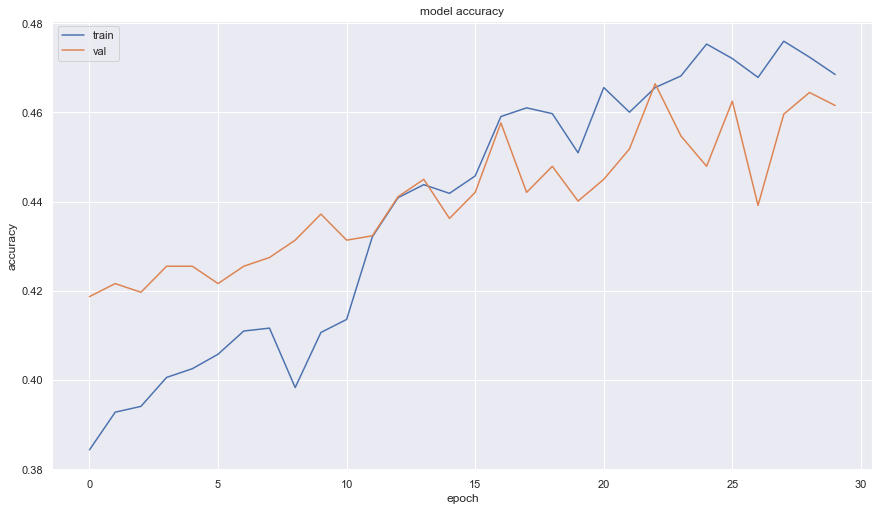

In [612]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

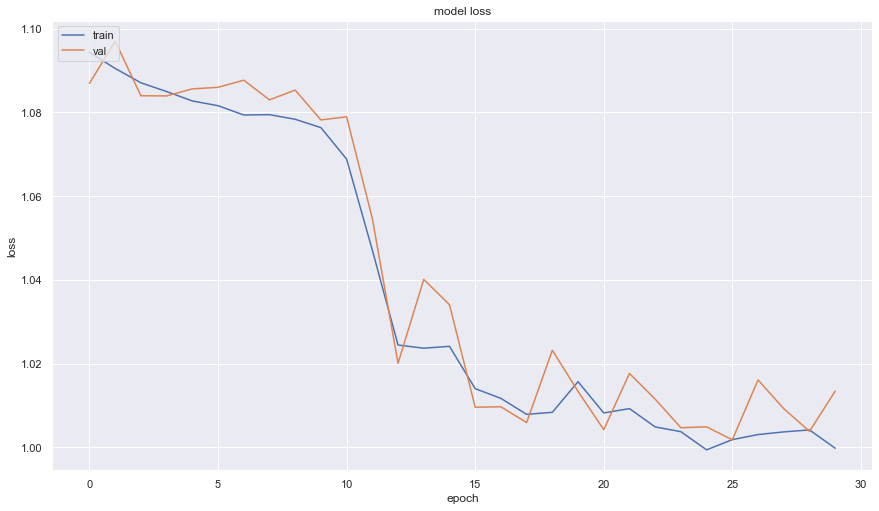

In [613]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [614]:
model.save(source_data_toSave + file_name_toSave)

In [615]:
#Load Model
model = tf.keras.models.load_model(source_data_toSave + file_name_toSave)

In [616]:
def precision(label, confusion_matrix):
    #print('label',label)
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [617]:
#y_test_pred.shape

### PREDICTION AND CONFUSION MATRIX TEST

In [618]:
#TEST Real Test Subset
y_test_pred = model.predict(X_test_np)

In [619]:
ID = 4
print(y_test_pred[ID])
print(y_test_np[:ID])

[0.18101928 0.5259162  0.29306445]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [620]:
# Convierte de Probabilidad a 0 -1 y 1
uniques_y_test_pred = uniques[y_test_pred.argmax(1)]
uniques_y_test_np = uniques[y_test_np.argmax(1)]

In [621]:
conf_matrix_test = confusion_matrix(uniques_y_test_np, uniques_y_test_pred)
conf_matrix_test

array([[  1, 146,  60],
       [  1, 376,  45],
       [  3, 139,  57]], dtype=int64)

In [622]:
print("indx Value Precision Recall")
for label in uniques:
    indx = int(np.where(uniques == label)[0])
    print (indx)
    print(f"{int(label):5d}    {precision(indx, conf_matrix_test):9.3f}    {recall(indx, conf_matrix_test):6.3f}")

indx Value Precision Recall
0
   -1        0.200     0.005
1
    0        0.569     0.891
2
    1        0.352     0.286


In [623]:
print("precision total:", precision_macro_average(conf_matrix_test))
print("recall total:", recall_macro_average(conf_matrix_test))

precision total: 0.3735623167292355
recall total: 0.3940861131139745


In [624]:
ACC_Test = accuracy(conf_matrix_test)
ACC_Test

0.5241545893719807

###  PREDICTION AND CONFUSION MATRIX TRAIN

In [625]:
#TRAIN
y_train_pred = model.predict(X_train_np)
print(X_train_np.shape)

print(y_train_pred.shape)
print(y_train_np.shape)

(3078, 5, 94)
(3078, 3)
(3078, 3)


In [626]:
ID = 4
print(y_train_pred[:ID])
print(y_train_np[:ID])

[[0.30055022 0.27240258 0.42704716]
 [0.10759955 0.7774422  0.11495816]
 [0.311126   0.33733264 0.35154137]
 [0.32025748 0.29747072 0.38227174]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [627]:
uniques_y_train_pred = uniques[y_train_pred.argmax(1)]
uniques_y_train_np = uniques[y_train_np.argmax(1)]
print(uniques_y_train_pred)
print(uniques_y_train_pred.shape)
print(uniques_y_train_np)
print(uniques_y_train_np.shape)

[1. 0. 1. ... 0. 0. 0.]
(3078,)
[-1.  0.  1. ...  0.  0.  0.]
(3078,)


In [628]:
print(uniques)

[-1.  0.  1.]


In [629]:
conf_matrix_train = confusion_matrix(uniques_y_train_np, uniques_y_train_pred)
conf_matrix_train

array([[115, 213, 596],
       [ 42, 668, 471],
       [ 70, 217, 686]], dtype=int64)

In [630]:
print("indx Value Precision Recall")
for label in uniques:
    indx = int(np.where(uniques == label)[0])
    print (indx)
    print(f"{int(label):5d}    {precision(indx, conf_matrix_train):9.3f}    {recall(indx, conf_matrix_train):6.3f}")

indx Value Precision Recall
0
   -1        0.507     0.124
1
    0        0.608     0.566
2
    1        0.391     0.705


In [631]:
print("precision total:", precision_macro_average(conf_matrix_train))
print("recall total:", recall_macro_average(conf_matrix_train))

precision total: 0.5021053167392979
recall total: 0.46503906653974575


In [632]:
ACC_Train = accuracy(conf_matrix_train)
ACC_Train

0.47725795971410007

### Test  RESULTS TO CSV

In [633]:
print("data_test.shape: ", data_test.shape)
data_test


data_test.shape:  (828, 94)


,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,...,trend_kst_diff,trend_aroon_up,trend_aroon_down,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dlr,others_cr
4110,1.17319,1.17438,1.17308,1.17427,8920.6504,1.17271,1.17435,1.17267,1.17424,9578.3701,...,-5.864074,4.0,92.0,43.999116,21.784542,15.371693,-78.215458,-0.014482,0.077525,-6.606062
4111,1.17427,1.17562,1.17198,1.17414,152661.7344,1.17422,1.17561,1.17195,1.17410,147124.0000,...,-5.131650,32.0,88.0,44.961219,26.853933,22.569136,-73.146067,-0.013845,-0.011071,-6.616401
4112,1.17412,1.18259,1.17408,1.18138,214738.0938,1.17410,1.18254,1.17405,1.18134,213520.0938,...,-4.167188,28.0,84.0,55.465320,53.970037,34.202837,-46.029963,-0.013264,0.614728,-6.040578
4113,1.18135,1.18694,1.17955,1.18644,216994.3750,1.18134,1.18690,1.17952,1.18641,216780.8750,...,-3.159571,24.0,80.0,60.456536,97.496244,59.440071,-2.503756,-0.011155,0.427398,-5.638138
4114,1.18641,1.18799,1.18254,1.18314,204817.6406,1.18640,1.18797,1.18252,1.18309,202787.5313,...,-2.276570,20.0,76.0,58.808316,76.926736,76.131006,-23.073264,-0.008103,-0.278531,-5.900599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4933,1.09019,1.09960,1.08970,1.09787,221915.4388,1.09015,1.09957,1.08969,1.09784,207536.2810,...,3.434440,16.0,32.0,53.470734,87.194861,66.181299,-12.805139,0.005839,0.701995,-12.682430
4934,1.09788,1.10311,1.09342,1.10169,339215.8879,1.09785,1.10307,1.09340,1.10166,319490.5464,...,3.785981,100.0,28.0,60.537067,94.453125,78.650685,-5.546875,0.005649,0.347343,-12.378612
4935,1.10168,1.10937,1.09919,1.10782,290715.4826,1.10165,1.10934,1.09916,1.10779,231205.2051,...,4.814614,100.0,24.0,63.147537,95.134965,92.260984,-4.865035,0.007610,0.554876,-11.891071
4936,1.10780,1.11452,1.10702,1.11071,330692.3901,1.10778,1.11451,1.10698,1.11036,373017.4493,...,5.625703,100.0,20.0,66.774381,89.705485,93.097858,-10.294515,0.011013,0.260533,-11.661219


In [634]:
data_test_res = data_test
data_test_res.reset_index(drop=True, inplace=True)
results_data_test = pd.DataFrame(data_test_res['Open'])
results_data_test['High'] = data_test_res['High']
results_data_test['Low'] = data_test_res['Low']
results_data_test['Close'] = data_test_res['Close']
results_data_test['Volume'] = data_test_res['Volume']
print(results_data_test)

        Open     High      Low    Close       Volume
0    1.17319  1.17438  1.17308  1.17427    8920.6504
1    1.17427  1.17562  1.17198  1.17414  152661.7344
2    1.17412  1.18259  1.17408  1.18138  214738.0938
3    1.18135  1.18694  1.17955  1.18644  216994.3750
4    1.18641  1.18799  1.18254  1.18314  204817.6406
..       ...      ...      ...      ...          ...
823  1.09019  1.09960  1.08970  1.09787  221915.4388
824  1.09788  1.10311  1.09342  1.10169  339215.8879
825  1.10168  1.10937  1.09919  1.10782  290715.4826
826  1.10780  1.11452  1.10702  1.11071  330692.3901
827  1.11213  1.11217  1.11028  1.11158   10126.4174

[828 rows x 5 columns]


In [635]:

uniques_y_test_pred_pd = pd.DataFrame({'Real_Class': uniques_y_test_pred[:]})
print(uniques_y_test_pred_pd)

     Real_Class
0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
..          ...
823         1.0
824         0.0
825         0.0
826         0.0
827         0.0

[828 rows x 1 columns]


In [636]:
results_data_test['Real_Class'] = uniques_y_test_np
results_data_test['Predicted_Class'] = uniques_y_test_pred_pd

In [637]:
results_data_test.head(10)

,Open,High,Low,Close,Volume,Real_Class,Predicted_Class
0,1.17319,1.17438,1.17308,1.17427,8920.6504,0.0,0.0
1,1.17427,1.17562,1.17198,1.17414,152661.7344,1.0,0.0
2,1.17412,1.18259,1.17408,1.18138,214738.0938,1.0,0.0
3,1.18135,1.18694,1.17955,1.18644,216994.3750,-1.0,0.0
4,1.18641,1.18799,1.18254,1.18314,204817.6406,0.0,0.0
5,1.18314,1.18750,1.18055,1.18223,199182.5000,0.0,0.0
6,1.18150,1.18183,1.18059,1.18149,7389.2700,0.0,0.0
7,1.18149,1.18199,1.17808,1.17948,187651.9063,0.0,0.0
8,1.17946,1.17953,1.17362,1.17716,192445.1250,0.0,1.0
9,1.17712,1.18056,1.17304,1.17946,195770.4844,1.0,0.0


In [638]:
#SAVE
results_data_test.to_csv(test_results_csv, header=True, index=False)
test_results_csv

'C:\\Users\\maw\\Documents\\ITESO\\forex_prediction\\Jupyter Notebooks\\IDI4\\models_clasification\\../../../Results/LSTM/Optimized/3C-EURUSD_FULL_1D_145F_0.002Sep_33_Test.csv'

### TRAIN RESULTS TO CSV

In [639]:
print("data_train.shape: ", data_training.shape)


data_train.shape:  (3083, 94)


In [640]:
data_training_res = data_training
data_training_res.reset_index(drop=True, inplace=True)
results_data_train = pd.DataFrame(data_training_res['Open'])
results_data_train['High'] = data_training_res['High']
results_data_train['Low'] = data_training_res['Low']
results_data_train['Close'] = data_training_res['Close']
results_data_train['Volume'] = data_training_res['Volume']
print(results_data_train)
print(results_data_train.shape)
results_data_train = results_data_train.iloc[RANGE:]
results_data_train.reset_index(drop=True, inplace=True)
print(results_data_train.shape)

         Open     High      Low    Close        Volume
0     1.23655  1.23817  1.22801  1.23179  1.078729e+06
1     1.23158  1.23241  1.22967  1.23109  8.212280e+04
2     1.23140  1.23154  1.21310  1.21496  1.130388e+06
3     1.21495  1.21669  1.20594  1.20711  1.123270e+06
4     1.20718  1.21160  1.20519  1.20794  1.118725e+06
...       ...      ...      ...      ...           ...
3078  1.36104  1.36340  1.35645  1.36007  1.962209e+05
3079  1.35912  1.35992  1.35909  1.35914  5.434240e+03
3080  1.35913  1.36137  1.35742  1.36004  2.521172e+05
3081  1.36004  1.36279  1.35836  1.36060  2.456597e+05
3082  1.36060  1.36514  1.36006  1.36282  3.139254e+05

[3083 rows x 5 columns]
(3083, 5)
(3078, 5)


In [641]:
print(uniques_y_train_pred[:])
print(uniques_y_train_pred.shape)

[1. 0. 1. ... 0. 0. 0.]
(3078,)


In [642]:

uniques_y_train_pred_pd = pd.DataFrame({'Real_Class': uniques_y_train_pred[:]})
print(uniques_y_train_pred_pd)
print(uniques_y_train_pred_pd.shape)


      Real_Class
0            1.0
1            0.0
2            1.0
3            1.0
4            1.0
...          ...
3073         0.0
3074         0.0
3075         0.0
3076         0.0
3077         0.0

[3078 rows x 1 columns]
(3078, 1)


In [643]:
results_data_train['Real_Class'] = uniques_y_train_np
results_data_train['Predicted_Class'] = uniques_y_train_pred_pd

In [644]:
results_data_train.head(10)
#results_data_train.tail(10)

,Open,High,Low,Close,Volume,Real_Class,Predicted_Class
0,1.20780,1.21167,1.20465,1.21079,1.126558e+06,-1.0,1.0
1,1.21063,1.21349,1.20005,1.20102,1.065118e+06,0.0,0.0
2,1.20131,1.20189,1.20019,1.20096,7.733910e+04,1.0,1.0
3,1.20087,1.20685,1.19860,1.20468,1.124832e+06,1.0,1.0
4,1.20455,1.21946,1.20442,1.21778,1.117748e+06,0.0,1.0
5,1.21754,1.22208,1.21466,1.21889,1.106444e+06,0.0,1.0
6,1.21899,1.21999,1.21408,1.21666,1.132577e+06,-1.0,1.0
7,1.21663,1.21931,1.20414,1.20558,1.063896e+06,0.0,0.0
8,1.20628,1.20701,1.20509,1.20662,7.789710e+04,0.0,0.0
9,1.20657,1.20802,1.20459,1.20650,1.110041e+06,0.0,1.0


In [645]:
uniques_y_train_np[:20]

array([-1.,  0.,  1.,  1.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  1.,  1.,
        0.,  0.,  0., -1.,  1.,  0.,  0.])

In [646]:
#Save
#results_data_train.to_csv(train_results_csv, header=True, index=False)
train_results_csv

'C:\\Users\\maw\\Documents\\ITESO\\forex_prediction\\Jupyter Notebooks\\IDI4\\models_clasification\\../../../Results/LSTM/Optimized/3C-EURUSD_FULL_1D_145F_0.002Sep_33_Train.csv'

## LSTM Optimized Results

In [647]:
#FILENAME =   str(RANGE) + 'Prof_' + str(EPOCHS) + 'Epochs' + '_' +  "{:.2f}".format(acc) + 'acc_' + TARGET_NAME + "_"+ str(newID) 

data = {'Input_Dataset_Name':[FILENAME], 'Profundidad':[RANGE], 'TEST_SIZE':[TEST_SIZE], 'VAL_SIZE':[VAL_SIZE],
        'Model_Name':[file_name_toSave], 'DataSet_Size':[str(SIZE)], 'EPOCAS':[str(EPOCHS)], 
        'ACC_Test':[ACC_Test], 'ACC_Train':[ACC_Train], 'LAYER1_UNITS':[LAYER1_UNITS]}

Results = pd.DataFrame(data)
print(Results)

filename = 'LSTM_Optimized_Results.csv'
print(filename)

filename_path = os.path.join(pwd, r'../../../Results/LSTM/Optimized/Results/' + filename)
print(filename_path)

                   Input_Dataset_Name  Profundidad  TEST_SIZE  VAL_SIZE  \
0  3C-EURUSD_FULL_1D_145F_0.002Sep_33            5        0.2       0.2   

                                Model_Name DataSet_Size EPOCAS  ACC_Test  \
0  3C-EURUSD_FULL_1D_145F_0.002Sep_33.hdf5         5137     30  0.524155   

   ACC_Train  LAYER1_UNITS  
0   0.477258            64  
LSTM_Optimized_Results.csv
C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/LSTM/Optimized/Results/LSTM_Optimized_Results.csv


In [648]:
Results_loaded = pd.read_csv(filename_path, header=0)

In [649]:
Results_loaded = Results_loaded.append(Results,ignore_index=True)
print(Results_loaded[-1:])

                    Input_Dataset_Name  Profundidad  TEST_SIZE  VAL_SIZE  \
18  3C-EURUSD_FULL_1D_145F_0.002Sep_33            5        0.2       0.2   

                                 Model_Name DataSet_Size EPOCAS  ACC_Test  \
18  3C-EURUSD_FULL_1D_145F_0.002Sep_33.hdf5         5137     30  0.524155   

    ACC_Train  LAYER1_UNITS  
18   0.477258            64  


In [650]:
Results_loaded.to_csv(filename_path, header=True, index=False)

In [651]:
Results_loaded
Only_high = Results_loaded.loc[Results_loaded['ACC_Test'] > 0.49]
Only_high

,Input_Dataset_Name,Profundidad,TEST_SIZE,VAL_SIZE,Model_Name,DataSet_Size,EPOCAS,ACC_Test,ACC_Train,LAYER1_UNITS
0,3C-EURUSD_FULL_1D_145F_0.002Sep_1,4,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_1.hdf5,5137,100,0.515700,0.463787,8
1,3C-EURUSD_FULL_1D_145F_0.002Sep_1,4,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_1.hdf5,5137,100,0.515700,0.463787,8
4,3C-EURUSD_FULL_1D_145F_0.002Sep_5,11,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_5.hdf5,5137,100,0.491546,0.478841,8
5,3C-EURUSD_FULL_1D_145F_0.002Sep_7,1,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_7.hdf5,5137,100,0.507246,0.416937,8
6,3C-EURUSD_FULL_1D_145F_0.002Sep_9,1,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_9.hdf5,5137,100,0.503623,0.413692,8
8,3C-EURUSD_FULL_1D_145F_0.002Sep_13,5,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_13.hdf5,5137,100,0.514493,0.491553,8
10,3C-EURUSD_FULL_1D_145F_0.002Sep_17,5,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_17.hdf5,5137,100,0.512077,0.475634,8
11,3C-EURUSD_FULL_1D_145F_0.002Sep_19,6,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_19.hdf5,5137,100,0.503623,0.507637,8
12,3C-EURUSD_FULL_1D_145F_0.002Sep_21,3,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_21.hdf5,5137,100,0.508454,0.459416,8
13,3C-EURUSD_FULL_1D_145F_0.002Sep_23,3,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_23.hdf5,5137,100,0.510870,0.425974,32


In [652]:
Only_high

,Input_Dataset_Name,Profundidad,TEST_SIZE,VAL_SIZE,Model_Name,DataSet_Size,EPOCAS,ACC_Test,ACC_Train,LAYER1_UNITS
0,3C-EURUSD_FULL_1D_145F_0.002Sep_1,4,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_1.hdf5,5137,100,0.515700,0.463787,8
1,3C-EURUSD_FULL_1D_145F_0.002Sep_1,4,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_1.hdf5,5137,100,0.515700,0.463787,8
4,3C-EURUSD_FULL_1D_145F_0.002Sep_5,11,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_5.hdf5,5137,100,0.491546,0.478841,8
5,3C-EURUSD_FULL_1D_145F_0.002Sep_7,1,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_7.hdf5,5137,100,0.507246,0.416937,8
6,3C-EURUSD_FULL_1D_145F_0.002Sep_9,1,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_9.hdf5,5137,100,0.503623,0.413692,8
8,3C-EURUSD_FULL_1D_145F_0.002Sep_13,5,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_13.hdf5,5137,100,0.514493,0.491553,8
10,3C-EURUSD_FULL_1D_145F_0.002Sep_17,5,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_17.hdf5,5137,100,0.512077,0.475634,8
11,3C-EURUSD_FULL_1D_145F_0.002Sep_19,6,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_19.hdf5,5137,100,0.503623,0.507637,8
12,3C-EURUSD_FULL_1D_145F_0.002Sep_21,3,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_21.hdf5,5137,100,0.508454,0.459416,8
13,3C-EURUSD_FULL_1D_145F_0.002Sep_23,3,0.2,0.2,3C-EURUSD_FULL_1D_145F_0.002Sep_23.hdf5,5137,100,0.510870,0.425974,32


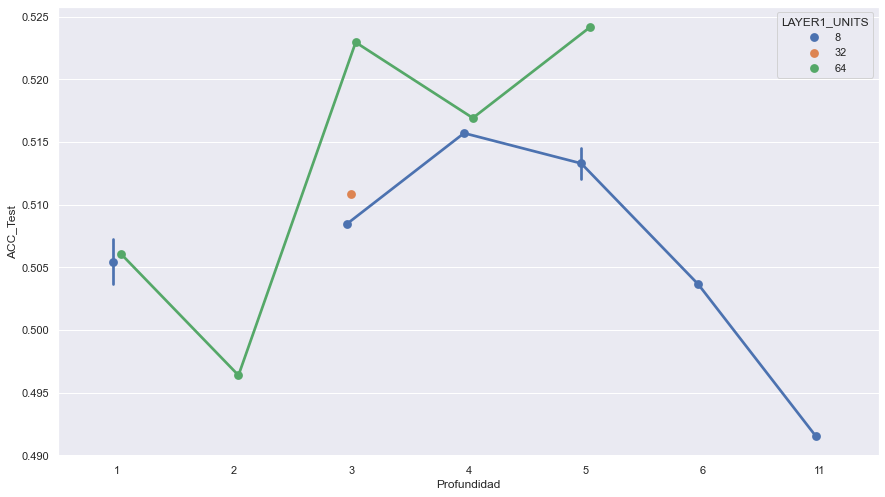

In [653]:
sns.set(rc={'figure.figsize':(14.7,8.27)})
sns.pointplot(x="Profundidad", y="ACC_Test",  hue="LAYER1_UNITS", data=Only_high, dodge=True,labelbottom = True,bottom=True);


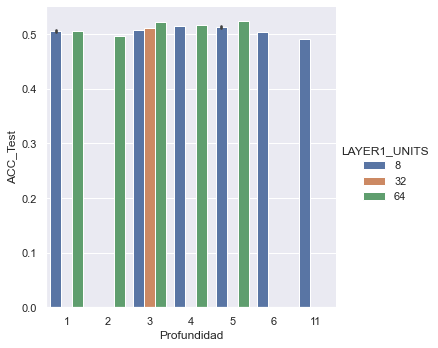

In [654]:

#print(subset_to_plot)
sns.set(rc={'figure.figsize':(14.7,8.27)})
sns.catplot(x="Profundidad", y="ACC_Test",   hue="LAYER1_UNITS", data=Only_high, kind="bar");

In [655]:
ACC_Test

0.5241545893719807